<a href="https://colab.research.google.com/github/fish34/sberbank_data_analysis/blob/master/Project/3_Analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.naive_bayes as nbyes
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [ ]:
# Скачаем файлы базы
!rm -rf /content/sberbank_data_analysis/
!git clone https://github.com/fish34/sberbank_data_analysis.git
!unzip /content/Project/courses.zip


Cloning into 'DA_data'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 43 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (43/43), done.
Archive:  /content/DA_data/courses_cleaned.zip
  inflating: courses_cleaned.csv     


In [ ]:
df_all=pd.read_csv("/content/courses_cleaned.csv",index_col=0)

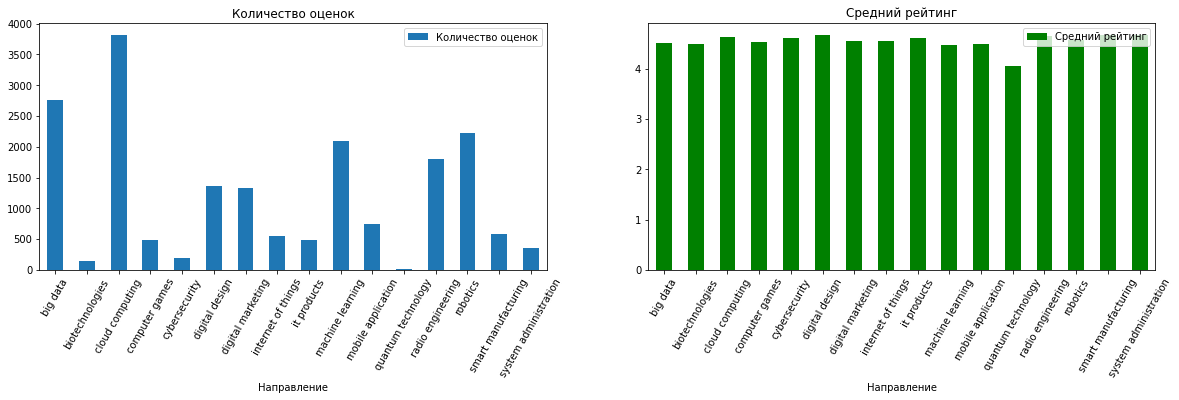

In [ ]:
# Выведем на гистограмме среднее значение оценок и рейтинга по каждому направлению

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
ax=plt.gca()
df_all.groupby(['direction'])['marks'].mean().plot.bar()
ax.set_xlabel('Направление')
plt.xticks(rotation=60)
ax.set_title('Количество оценок')
ax.legend(labels=['Количество оценок'])

plt.subplot(2,2,2)
ax=plt.gca()
df_all.groupby(['direction'])['rating'].mean().plot.bar(color='green')
ax.set_xlabel('Направление')
plt.xticks(rotation=60)
ax.set_title('Средний рейтинг')
ax.legend(labels=['Средний рейтинг'])

plt.show()

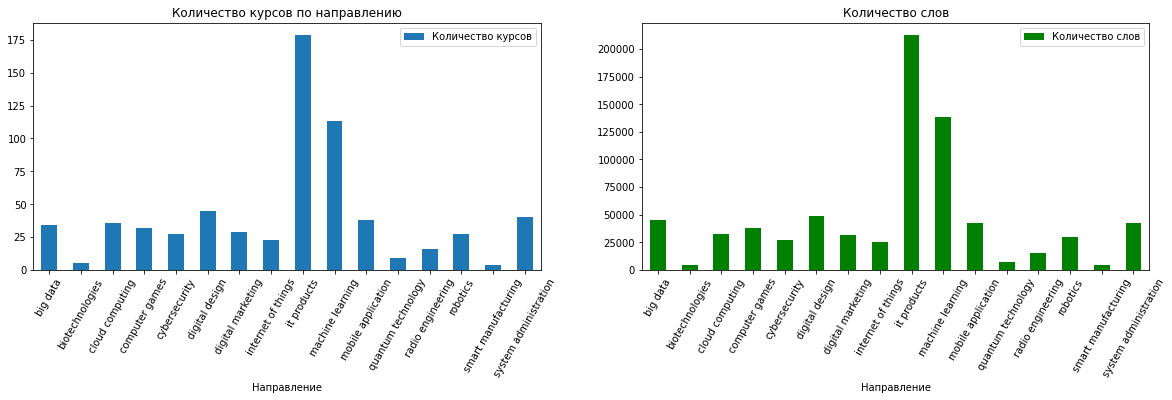

In [ ]:
# Отобразим гистограмму количества специализаций и курсов по каждому направлению. Видно, что выборка несбалансирована, значительное число курсов приходится на направление [it products]
# Отобразим балансировку числа слов от направлений. Так же видна несбалансированность числа слов от направлений.
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
ax=plt.gca()
df_all.groupby(['direction'])['direction'].count().plot.bar()
ax.set_xlabel('Направление')
plt.xticks(rotation=60)
ax.set_title('Количество курсов по направлению')
ax.legend(labels=['Количество курсов'])

plt.subplot(2,2,2)
ax=plt.gca()
df_all['words count']=df_all['descr'].str.len()
df_all_hist=df_all.groupby(['direction'])['words count'].sum().plot.bar(color='green')
ax.set_xlabel('Направление')
plt.xticks(rotation=60)
ax.set_title('Количество слов')
ax.legend(labels=['Количество слов'])

plt.show()

In [ ]:
# Выделим данные для построения модели.
courses=df_all[['descr','direction']]

In [ ]:
#Закодируем целевую переменную - направление.
encoders = {}
encoders['direction'] = preprocessing.LabelEncoder() # для колонки direction создаем кодировщик
courses['direction'] = encoders['direction'].fit_transform(courses['direction']) # применяем кодировщик к столбцу и перезаписываем столбец

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
courses

,descr,direction
0,"['drive', 'better', 'business', 'decisions', '...",0
1,"['interested', 'increasing', 'knowledge', 'big...",8
2,"['identified', 'big', 'data', 'issue', 'analyz...",3
3,"['end', 'course', 'able', 'retrieve', 'data', ...",2
4,"['want', 'make', 'sense', 'volumes', 'data', '...",9
...,...,...
652,"['getting', 'started', 'ibm', 'mainframe', 'zo...",15
653,"['foundational', 'knowledge', 'position', 'ibm...",15
654,"['world', 'runs', 'computers', 'watch', 'tv', ...",15
655,"['effective', 'measures', 'performance', 'asse...",15


In [ ]:
# Данные для анализа - направление и описание
X=courses['descr'].values
y=courses['direction'].values

(657, 2)


In [ ]:
# Класс для анализа. Используем TF-IDF трансформацию и NB классификатор по умолчанию.
class Classifier():
  def __init__(self,X,y,model = None):
    self.model=model or nbyes.ComplementNB()
    # Разделим выборку на тренировочную и проверочную
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=.15, random_state=33)
    # Трансформируем данные и наполним словарь
    self.vectorizer = TfidfVectorizer(ngram_range = (1,2))
    # Convert a collection of raw documents to a matrix of TF-IDF features.
    self.X_train = self.vectorizer.fit_transform(self.X_train)
    # Tf-idf-weighted document-term matrix
    self.X_test = self.vectorizer.transform(self.X_test)
    self.future_names = self.vectorizer.get_feature_names()
    # Тренируем модель
    self.model.fit(self.X_train, self.y_train)

  def classify(self, text):
    text_counts = self.vectorizer.transform(text)
    cls=self.model.predict(text_counts)
    self.predictions = encoders["direction"].inverse_transform(cls)
    self.predictions_c = self.model.predict_proba(text_counts)
    print(f'Predictions: {self.predictions}')
    print(f'Predictions for all classes: {self.predictions_c}')
    return self.predictions
  
  def getReport(self):
    self.y_predictions = self.model.predict(self.X_test)
    print(classification_report(self.y_test, self.y_predictions))
           
    #ConfMatrix - матрица ошибок
    #fig = plt.figure(figsize=(12,12))
    #nn_mtx = metrics.confusion_matrix(self.y_test, self.y_predictions)
    #matplotlib.rc('xtick', labelsize=12) 
    #matplotlib.rc('ytick', labelsize=12) 
    #sns.heatmap(nn_mtx, annot=True, fmt="d", 
    #            xticklabels=encoders["direction"].classes_,
    #            yticklabels=encoders["direction"].classes_)
    #plt.ylabel("Fact value")
    #plt.xlabel("Predicted value")
    print(nn_mtx)   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       1.00      0.67      0.80         6
           3       1.00      0.40      0.57         5
           4       0.50      0.25      0.33         4
           5       0.50      0.20      0.29        10
           6       0.00      0.00      0.00         5
           8       0.38      0.80      0.51        25
           9       0.58      0.64      0.61        22
          10       0.00      0.00      0.00         2
          11       1.00      0.33      0.50         3
          12       1.00      0.50      0.67         2
          13       1.00      0.20      0.33         5
          15       1.00      0.43      0.60         7

    accuracy                           0.53        99
   macro avg       0.67      0.42      0.47        99
weighted avg       0.60      0.53      0.50        99

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  2  0  0  0  0

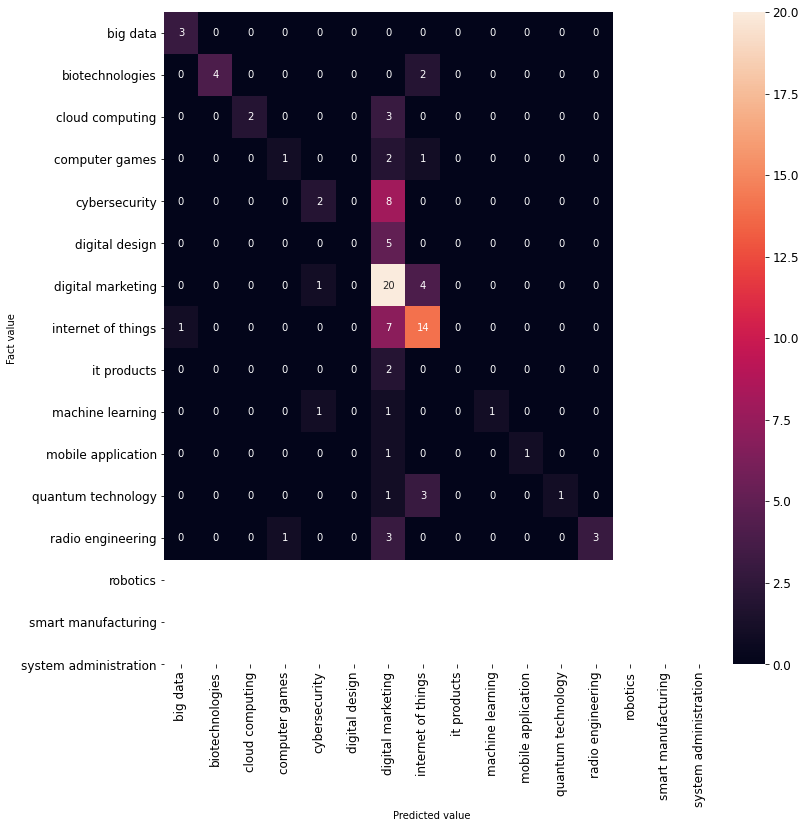

In [ ]:
# Показатели модели
# accuracy — доля правильных ответов алгоритма
# Для оценки качества работы алгоритма на каждом из классов по отдельности введем метрики precision (точность) и recall (полнота)
model_nb = Classifier(X,y)
model_nb.getReport()

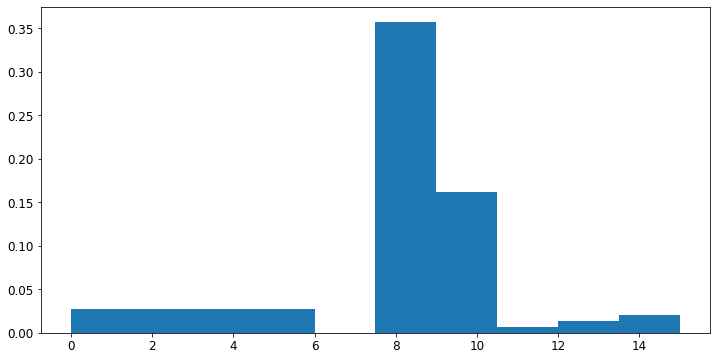

In [ ]:
# Отобразим данные тестовых предсказаний
plt.figure(figsize=(12, 6))
plt.hist(model_nb.y_predictions, density=True)
plt.show()

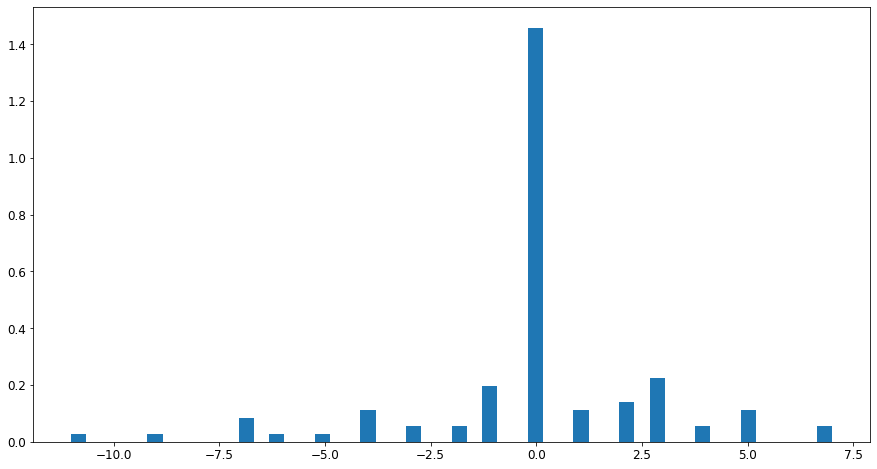

In [ ]:
# Отобразим разность предсказаний на гистограмме
diff = model_nb.y_predictions - model_nb.y_test
plt.figure(figsize=(15, 8))
plt.hist(diff, bins=50, density=True)
plt.show()

In [ ]:
# Показатели отчета не убедительные. Попробуем построить классификатор по модели KNN 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
# Зададим сетку - среди каких значений выбирать наилучший параметр.
knn_grid = {'n_neighbors': np.array(np.linspace(1, 100, 100), dtype='int')}

# Создаем объект кросс-валидации
gs = GridSearchCV(knn, knn_grid, cv=5)

# Обучаем его
model_knn=Classifier(X,y,model=gs)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


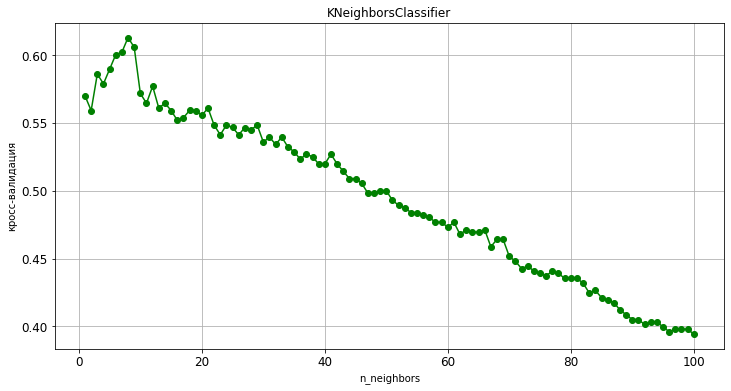

In [ ]:
def grid_plot(x, y, x_label, title, y_label='кросс-валидация'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
grid_plot(knn_grid['n_neighbors'], model_knn.model.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [ ]:
# Лучшие параметры
model_knn.model.best_params_, model_knn.model.best_score_

({'n_neighbors': 8}, 0.612934362934363)

In [ ]:
# Выполним тренировку классификатора с лучшим параметром
clf_knn = KNeighborsClassifier(n_neighbors=8)
model_knn=Classifier(X,y,model=clf_knn)
y_knn = model_knn.model.predict(model_knn.X_test)
model_knn.y_predictions=y_knn
y_knn

array([ 9, 15,  8,  8, 13, 15,  9,  0,  8,  8,  9, 13,  0,  0,  3,  0,  9,
        8, 10, 13,  5,  9,  9,  4,  8,  5, 15,  2, 15,  8,  6, 15,  8, 11,
        4, 12,  9,  8,  8,  9,  9,  5,  2,  9,  8,  9, 10,  2,  4,  0, 15,
        9,  8,  8, 15, 13, 11,  5,  9,  0,  8,  0,  9, 13, 13,  9,  9,  8,
       15,  8,  8,  8,  5, 13,  5,  9,  2,  5,  0,  2,  9,  3,  9,  9,  0,
        0,  3,  8,  8,  8,  9,  8,  8,  8,  6,  8,  9,  6,  2])

              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           2       0.50      0.50      0.50         6
           3       0.67      0.40      0.50         5
           4       0.67      0.50      0.57         4
           5       0.71      0.50      0.59        10
           6       0.67      0.40      0.50         5
           8       0.60      0.60      0.60        25
           9       0.55      0.55      0.55        22
          10       0.00      0.00      0.00         2
          11       1.00      0.67      0.80         3
          12       1.00      0.50      0.67         2
          13       0.71      1.00      0.83         5
          15       0.50      0.57      0.53         7

    accuracy                           0.57        99
   macro avg       0.61      0.55      0.55        99
weighted avg       0.60      0.57      0.57        99

[[ 3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0  2  0  0  0  0

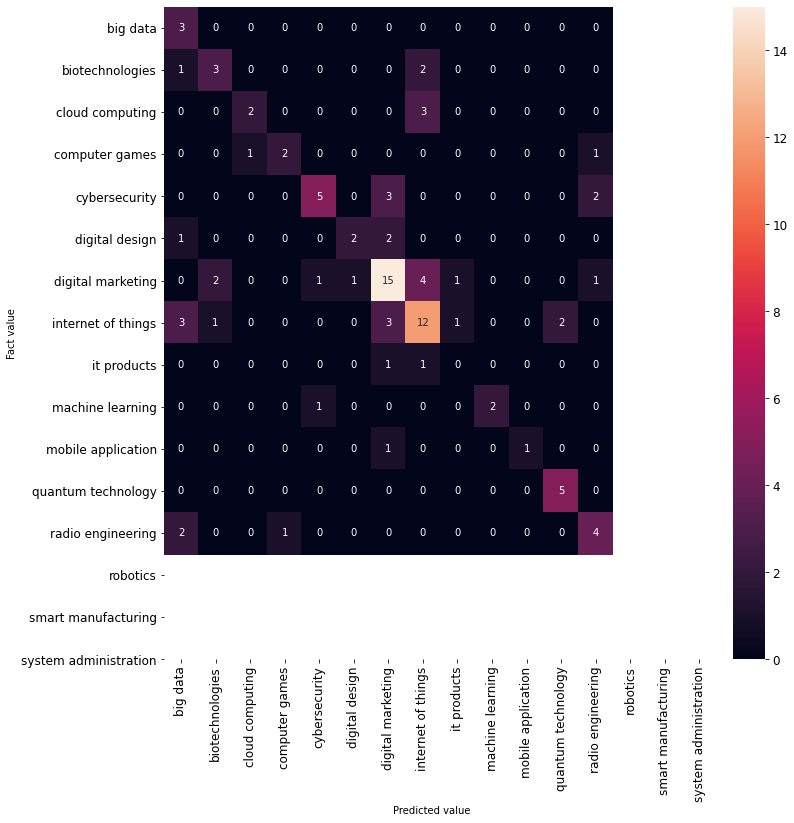

In [ ]:
# Посмотрим на метрики качества
model_knn.getReport()

Как видно, результат улучшился, но не настолько как бы нам хотелось. Делаем вывод, что проблема с данными, а именно их недостаточностью/не уникальностью для каждого класса.

In [ ]:
# Выполним классификацию по запросу
text = ['i want to learn machine learning']
model_knn.classify(text)
print(model_knn.predictions)
print(model_knn.predictions_c)

Predictions: ['machine learning']
Predictions for all classes: [[0.125 0.    0.    0.    0.    0.    0.    0.    0.    0.875 0.    0.
  0.    0.    0.    0.   ]]
['machine learning']
[[0.125 0.    0.    0.    0.    0.    0.    0.    0.    0.875 0.    0.
  0.    0.    0.    0.   ]]


In [ ]:
# На основе релевантности направлений, сформируем предложение курсов, учитывая их рейтинг и оценки
df_all.loc[df_all['direction']==model_knn.predictions[0]].sort_values(['marks','rating'], ascending=False).head(10)

,title,descr,marks,rating,url,program,direction,words count
554,Improving Deep Neural Networks: Hyperparameter...,"['course', 'teach', 'magic', 'getting', 'deep'...",40746.0,4.9,https://www.coursera.org/learn/deep-neural-net...,COURSE,machine learning,887
539,Structuring Machine Learning Projects,"['learn', 'build', 'successful', 'machine', 'l...",33476.0,4.8,https://www.coursera.org/learn/machine-learnin...,COURSE,machine learning,1174
537,The Data Scientistâs Toolbox,"['course', 'get', 'introduction', 'main', 'too...",21170.0,4.5,https://www.coursera.org/learn/data-scientists...,COURSE,machine learning,484
538,Introduction to Data Science in Python,"['course', 'introduce', 'learner', 'basics', '...",13148.0,4.5,https://www.coursera.org/learn/python-data-ana...,COURSE,machine learning,991
437,Machine Learning Foundations: A Case Study App...,"['data', 'wonder', 'tell', 'need', 'deeper', '...",9102.0,4.6,https://www.coursera.org/learn/ml-foundations,COURSE,machine learning,1762
395,AI For Everyone,"['ai', 'engineers', 'want', 'organization', 'b...",7314.0,4.8,https://www.coursera.org/learn/ai-for-everyone,COURSE,machine learning,722
47,A Crash Course in Data Science,"['definitely', 'heard', 'data', 'science', 'bi...",5211.0,4.5,https://www.coursera.org/learn/data-science-co...,COURSE,machine learning,1235
504,Machine Learning with Python,"['course', 'dives', 'basics', 'machine', 'lear...",4681.0,4.7,https://www.coursera.org/learn/machine-learnin...,COURSE,machine learning,1191
548,Machine Learning: Regression,"['case', 'study', 'predicting', 'housing', 'pr...",4464.0,4.8,https://www.coursera.org/learn/ml-regression,COURSE,machine learning,1383
90,How Google does Machine Learning,"['machine', 'learning', 'kinds', 'problems', '...",4452.0,4.6,https://www.coursera.org/learn/google-machine-...,COURSE,machine learning,596
